# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

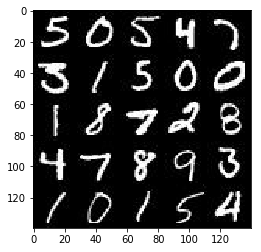

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

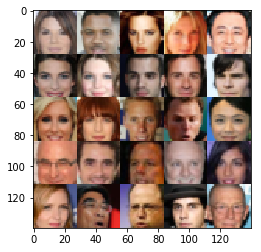

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function    
    image_tensor = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_tensor = tf.placeholder(tf.float32, [None, z_dim])
    lr_tensor = tf.placeholder(tf.float32, shape=None)
    return image_tensor, z_tensor, lr_tensor


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
               
        # Input layer is 28x28xChannels
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu3, (-1,7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
                
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
                
        x2 = tf.layers.conv2d_transpose(relu1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * x3, x3)
        # 28x28x64 now
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28xout_channel_dim
        
        out = tf.tanh(logits)
        
        return out  


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)    
    
    # Use label smoothing
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * np.random.uniform(0.7,1.2,1)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function    
    # Get the trainable variables to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)    
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model 
                steps += 1                
                
                # Rescaling input to [-1, 1]
                batch_images *= 2
                
                # Sample random noise for G                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers               
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                # Show the loss every 10 batches
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))                    
                
                # Show Generator output every 100 batches
                if steps % 100 == 0:                    
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7403... Generator Loss: 5.3814
Epoch 1/2... Discriminator Loss: 2.5116... Generator Loss: 4.4741
Epoch 1/2... Discriminator Loss: 1.9401... Generator Loss: 4.4428
Epoch 1/2... Discriminator Loss: 1.4922... Generator Loss: 1.3105
Epoch 1/2... Discriminator Loss: 1.3649... Generator Loss: 1.8497
Epoch 1/2... Discriminator Loss: 1.8854... Generator Loss: 1.5114
Epoch 1/2... Discriminator Loss: 1.4724... Generator Loss: 1.7983
Epoch 1/2... Discriminator Loss: 1.6795... Generator Loss: 1.6177
Epoch 1/2... Discriminator Loss: 1.6140... Generator Loss: 1.4916
Epoch 1/2... Discriminator Loss: 1.5435... Generator Loss: 1.4939


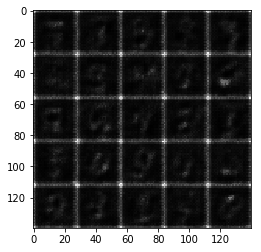

Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 1.5966
Epoch 1/2... Discriminator Loss: 1.3731... Generator Loss: 1.6284
Epoch 1/2... Discriminator Loss: 1.1144... Generator Loss: 0.9661
Epoch 1/2... Discriminator Loss: 1.4086... Generator Loss: 1.5737
Epoch 1/2... Discriminator Loss: 1.2193... Generator Loss: 1.4595
Epoch 1/2... Discriminator Loss: 1.1018... Generator Loss: 1.4072
Epoch 1/2... Discriminator Loss: 1.2915... Generator Loss: 1.5874
Epoch 1/2... Discriminator Loss: 0.9913... Generator Loss: 0.9453
Epoch 1/2... Discriminator Loss: 1.3121... Generator Loss: 1.8798
Epoch 1/2... Discriminator Loss: 1.0117... Generator Loss: 1.5853


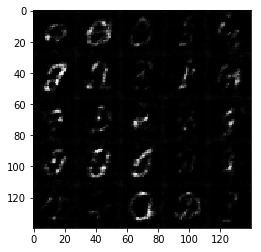

Epoch 1/2... Discriminator Loss: 0.9054... Generator Loss: 0.9960
Epoch 1/2... Discriminator Loss: 0.8766... Generator Loss: 1.4151
Epoch 1/2... Discriminator Loss: 1.0352... Generator Loss: 1.9664
Epoch 1/2... Discriminator Loss: 0.9817... Generator Loss: 1.8092
Epoch 1/2... Discriminator Loss: 1.0139... Generator Loss: 2.1848
Epoch 1/2... Discriminator Loss: 0.9085... Generator Loss: 1.3950
Epoch 1/2... Discriminator Loss: 0.8087... Generator Loss: 1.6291
Epoch 1/2... Discriminator Loss: 1.4249... Generator Loss: 2.8918
Epoch 1/2... Discriminator Loss: 0.7310... Generator Loss: 1.0529
Epoch 1/2... Discriminator Loss: 0.6988... Generator Loss: 1.4675


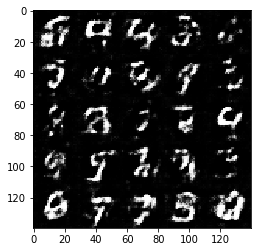

Epoch 1/2... Discriminator Loss: 0.5699... Generator Loss: 1.4460
Epoch 1/2... Discriminator Loss: 0.8503... Generator Loss: 0.8608
Epoch 1/2... Discriminator Loss: 0.6343... Generator Loss: 1.0719
Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 2.0602
Epoch 1/2... Discriminator Loss: 0.7763... Generator Loss: 1.1490
Epoch 1/2... Discriminator Loss: 0.6775... Generator Loss: 1.4743
Epoch 1/2... Discriminator Loss: 0.9181... Generator Loss: 1.7085
Epoch 1/2... Discriminator Loss: 1.0862... Generator Loss: 1.8942
Epoch 1/2... Discriminator Loss: 1.2209... Generator Loss: 2.1896
Epoch 1/2... Discriminator Loss: 0.7243... Generator Loss: 2.3249


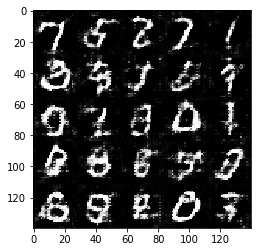

Epoch 1/2... Discriminator Loss: 1.0584... Generator Loss: 1.6603
Epoch 1/2... Discriminator Loss: 1.2284... Generator Loss: 1.4395
Epoch 1/2... Discriminator Loss: 2.0945... Generator Loss: 0.1770
Epoch 1/2... Discriminator Loss: 1.8449... Generator Loss: 0.2342
Epoch 1/2... Discriminator Loss: 1.2030... Generator Loss: 0.5386
Epoch 1/2... Discriminator Loss: 1.5084... Generator Loss: 0.3713
Epoch 1/2... Discriminator Loss: 1.5331... Generator Loss: 0.3279
Epoch 1/2... Discriminator Loss: 1.4372... Generator Loss: 0.3873
Epoch 1/2... Discriminator Loss: 1.2502... Generator Loss: 0.4380
Epoch 1/2... Discriminator Loss: 1.7297... Generator Loss: 0.2969


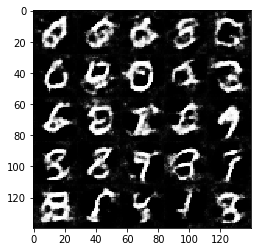

Epoch 1/2... Discriminator Loss: 1.2614... Generator Loss: 0.4481
Epoch 1/2... Discriminator Loss: 1.4372... Generator Loss: 0.3545
Epoch 1/2... Discriminator Loss: 1.3667... Generator Loss: 0.4265
Epoch 1/2... Discriminator Loss: 1.3319... Generator Loss: 0.3779
Epoch 1/2... Discriminator Loss: 0.9473... Generator Loss: 0.7373
Epoch 1/2... Discriminator Loss: 1.1918... Generator Loss: 1.8320
Epoch 1/2... Discriminator Loss: 1.1228... Generator Loss: 1.5366
Epoch 1/2... Discriminator Loss: 0.9280... Generator Loss: 0.9880
Epoch 1/2... Discriminator Loss: 1.0104... Generator Loss: 1.4220
Epoch 1/2... Discriminator Loss: 1.3867... Generator Loss: 1.7176


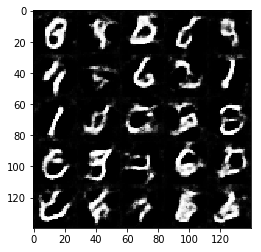

Epoch 1/2... Discriminator Loss: 1.1715... Generator Loss: 2.0560
Epoch 1/2... Discriminator Loss: 0.9094... Generator Loss: 1.0041
Epoch 1/2... Discriminator Loss: 1.0622... Generator Loss: 1.4994
Epoch 1/2... Discriminator Loss: 0.9768... Generator Loss: 1.5467
Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 0.8881
Epoch 1/2... Discriminator Loss: 1.4187... Generator Loss: 0.4039
Epoch 1/2... Discriminator Loss: 1.0694... Generator Loss: 0.5748
Epoch 1/2... Discriminator Loss: 1.3950... Generator Loss: 0.3856
Epoch 1/2... Discriminator Loss: 0.9924... Generator Loss: 0.7298
Epoch 1/2... Discriminator Loss: 1.5159... Generator Loss: 0.3065


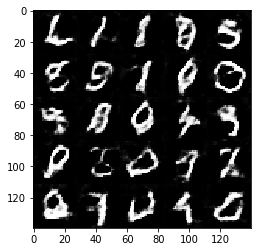

Epoch 1/2... Discriminator Loss: 1.2425... Generator Loss: 0.4552
Epoch 1/2... Discriminator Loss: 0.9658... Generator Loss: 0.8586
Epoch 1/2... Discriminator Loss: 1.0891... Generator Loss: 0.5722
Epoch 1/2... Discriminator Loss: 1.4885... Generator Loss: 0.3414
Epoch 1/2... Discriminator Loss: 1.3474... Generator Loss: 0.3983
Epoch 1/2... Discriminator Loss: 1.1088... Generator Loss: 0.5626
Epoch 1/2... Discriminator Loss: 1.5272... Generator Loss: 0.3219
Epoch 1/2... Discriminator Loss: 1.5120... Generator Loss: 0.3437
Epoch 1/2... Discriminator Loss: 0.8457... Generator Loss: 0.9425
Epoch 1/2... Discriminator Loss: 1.1967... Generator Loss: 0.5272


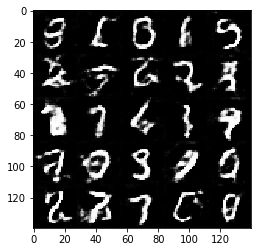

Epoch 1/2... Discriminator Loss: 1.8787... Generator Loss: 0.2111
Epoch 1/2... Discriminator Loss: 1.1106... Generator Loss: 0.5687
Epoch 1/2... Discriminator Loss: 1.1119... Generator Loss: 0.5525
Epoch 1/2... Discriminator Loss: 1.2698... Generator Loss: 0.4277
Epoch 1/2... Discriminator Loss: 1.4648... Generator Loss: 0.3181
Epoch 1/2... Discriminator Loss: 2.7804... Generator Loss: 0.0899
Epoch 1/2... Discriminator Loss: 0.7961... Generator Loss: 0.8451
Epoch 1/2... Discriminator Loss: 0.8768... Generator Loss: 0.8828
Epoch 1/2... Discriminator Loss: 2.7016... Generator Loss: 0.0936
Epoch 1/2... Discriminator Loss: 0.8845... Generator Loss: 0.7594


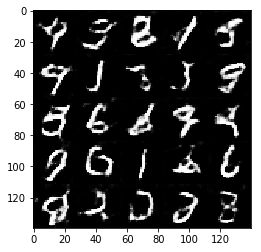

Epoch 1/2... Discriminator Loss: 1.1293... Generator Loss: 0.5102
Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 0.3918
Epoch 1/2... Discriminator Loss: 1.3971... Generator Loss: 0.3748
Epoch 2/2... Discriminator Loss: 1.1188... Generator Loss: 0.5740
Epoch 2/2... Discriminator Loss: 0.7528... Generator Loss: 1.1231
Epoch 2/2... Discriminator Loss: 0.9216... Generator Loss: 0.8086
Epoch 2/2... Discriminator Loss: 0.7758... Generator Loss: 1.0466
Epoch 2/2... Discriminator Loss: 1.4034... Generator Loss: 0.3674
Epoch 2/2... Discriminator Loss: 1.5676... Generator Loss: 0.2898
Epoch 2/2... Discriminator Loss: 1.0762... Generator Loss: 0.6045


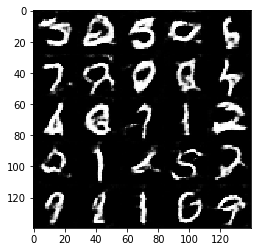

Epoch 2/2... Discriminator Loss: 0.8190... Generator Loss: 0.8322
Epoch 2/2... Discriminator Loss: 0.8151... Generator Loss: 1.0573
Epoch 2/2... Discriminator Loss: 0.6196... Generator Loss: 1.2884
Epoch 2/2... Discriminator Loss: 3.6106... Generator Loss: 4.3491
Epoch 2/2... Discriminator Loss: 1.0471... Generator Loss: 0.6958
Epoch 2/2... Discriminator Loss: 1.1747... Generator Loss: 0.5072
Epoch 2/2... Discriminator Loss: 0.8607... Generator Loss: 1.4935
Epoch 2/2... Discriminator Loss: 0.8946... Generator Loss: 1.6913
Epoch 2/2... Discriminator Loss: 0.6912... Generator Loss: 1.0613
Epoch 2/2... Discriminator Loss: 1.0052... Generator Loss: 0.8126


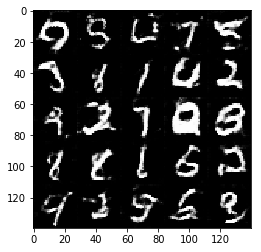

Epoch 2/2... Discriminator Loss: 1.1076... Generator Loss: 0.5764
Epoch 2/2... Discriminator Loss: 1.0242... Generator Loss: 0.6094
Epoch 2/2... Discriminator Loss: 2.8806... Generator Loss: 0.1043
Epoch 2/2... Discriminator Loss: 0.9442... Generator Loss: 0.7076
Epoch 2/2... Discriminator Loss: 1.0805... Generator Loss: 0.5576
Epoch 2/2... Discriminator Loss: 1.9154... Generator Loss: 0.2106
Epoch 2/2... Discriminator Loss: 1.0555... Generator Loss: 0.5888
Epoch 2/2... Discriminator Loss: 0.5925... Generator Loss: 1.2613
Epoch 2/2... Discriminator Loss: 1.0886... Generator Loss: 2.5379
Epoch 2/2... Discriminator Loss: 0.7624... Generator Loss: 1.2352


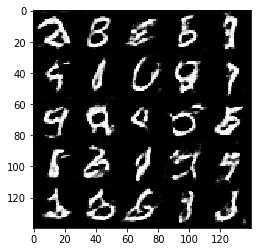

Epoch 2/2... Discriminator Loss: 0.8366... Generator Loss: 1.2281
Epoch 2/2... Discriminator Loss: 1.8699... Generator Loss: 2.7509
Epoch 2/2... Discriminator Loss: 0.9803... Generator Loss: 0.7456
Epoch 2/2... Discriminator Loss: 0.7556... Generator Loss: 0.9625
Epoch 2/2... Discriminator Loss: 0.7612... Generator Loss: 0.9493
Epoch 2/2... Discriminator Loss: 0.6125... Generator Loss: 1.2184
Epoch 2/2... Discriminator Loss: 1.1986... Generator Loss: 0.5234
Epoch 2/2... Discriminator Loss: 1.5883... Generator Loss: 0.3324
Epoch 2/2... Discriminator Loss: 1.2556... Generator Loss: 0.4987
Epoch 2/2... Discriminator Loss: 1.2776... Generator Loss: 0.4585


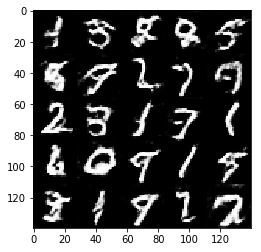

Epoch 2/2... Discriminator Loss: 0.8483... Generator Loss: 1.8113
Epoch 2/2... Discriminator Loss: 0.7967... Generator Loss: 1.5912
Epoch 2/2... Discriminator Loss: 0.8653... Generator Loss: 1.5537
Epoch 2/2... Discriminator Loss: 0.7550... Generator Loss: 0.9472
Epoch 2/2... Discriminator Loss: 1.3370... Generator Loss: 0.3811
Epoch 2/2... Discriminator Loss: 0.6733... Generator Loss: 1.1385
Epoch 2/2... Discriminator Loss: 1.1471... Generator Loss: 0.5407
Epoch 2/2... Discriminator Loss: 0.8269... Generator Loss: 0.9364
Epoch 2/2... Discriminator Loss: 1.5662... Generator Loss: 0.3062
Epoch 2/2... Discriminator Loss: 1.9887... Generator Loss: 0.2216


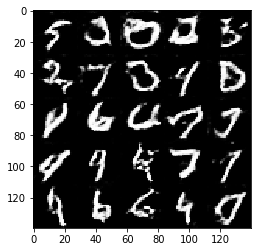

Epoch 2/2... Discriminator Loss: 1.1761... Generator Loss: 0.5373
Epoch 2/2... Discriminator Loss: 1.6115... Generator Loss: 0.2795
Epoch 2/2... Discriminator Loss: 1.0371... Generator Loss: 0.6630
Epoch 2/2... Discriminator Loss: 0.8698... Generator Loss: 1.3037
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 2.0757
Epoch 2/2... Discriminator Loss: 0.9855... Generator Loss: 1.4994
Epoch 2/2... Discriminator Loss: 1.3212... Generator Loss: 2.5304
Epoch 2/2... Discriminator Loss: 1.0272... Generator Loss: 0.7237
Epoch 2/2... Discriminator Loss: 0.9261... Generator Loss: 0.6749
Epoch 2/2... Discriminator Loss: 0.8205... Generator Loss: 0.8234


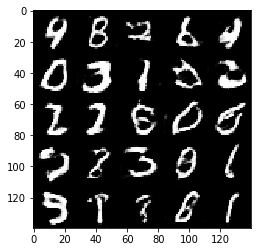

Epoch 2/2... Discriminator Loss: 0.6883... Generator Loss: 0.9859
Epoch 2/2... Discriminator Loss: 0.6829... Generator Loss: 1.3273
Epoch 2/2... Discriminator Loss: 1.4077... Generator Loss: 3.0201
Epoch 2/2... Discriminator Loss: 1.2019... Generator Loss: 1.8055
Epoch 2/2... Discriminator Loss: 0.7030... Generator Loss: 1.0938
Epoch 2/2... Discriminator Loss: 0.6904... Generator Loss: 1.4207
Epoch 2/2... Discriminator Loss: 0.8387... Generator Loss: 0.7796
Epoch 2/2... Discriminator Loss: 0.9869... Generator Loss: 0.7020
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.4129
Epoch 2/2... Discriminator Loss: 1.3843... Generator Loss: 0.4343


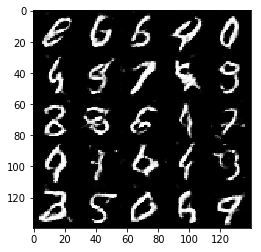

Epoch 2/2... Discriminator Loss: 0.6671... Generator Loss: 1.1220
Epoch 2/2... Discriminator Loss: 0.7707... Generator Loss: 0.8275
Epoch 2/2... Discriminator Loss: 0.8014... Generator Loss: 0.9192
Epoch 2/2... Discriminator Loss: 0.4692... Generator Loss: 1.6994
Epoch 2/2... Discriminator Loss: 0.8372... Generator Loss: 0.8400
Epoch 2/2... Discriminator Loss: 0.8238... Generator Loss: 1.0513
Epoch 2/2... Discriminator Loss: 1.0675... Generator Loss: 1.6665
Epoch 2/2... Discriminator Loss: 1.1056... Generator Loss: 2.0638
Epoch 2/2... Discriminator Loss: 0.9898... Generator Loss: 2.1423
Epoch 2/2... Discriminator Loss: 0.7608... Generator Loss: 1.8965


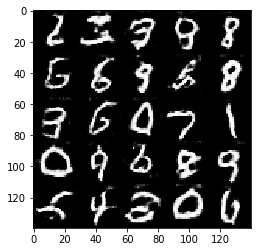

Epoch 2/2... Discriminator Loss: 0.7221... Generator Loss: 1.6174
Epoch 2/2... Discriminator Loss: 0.9621... Generator Loss: 1.9056
Epoch 2/2... Discriminator Loss: 0.9494... Generator Loss: 0.8031
Epoch 2/2... Discriminator Loss: 0.9133... Generator Loss: 0.7383
Epoch 2/2... Discriminator Loss: 0.6436... Generator Loss: 1.1482
Epoch 2/2... Discriminator Loss: 0.4258... Generator Loss: 2.2187
Epoch 2/2... Discriminator Loss: 2.2480... Generator Loss: 0.1842
Epoch 2/2... Discriminator Loss: 1.5383... Generator Loss: 0.3344
Epoch 2/2... Discriminator Loss: 0.8987... Generator Loss: 0.8952
Epoch 2/2... Discriminator Loss: 1.2377... Generator Loss: 2.4070


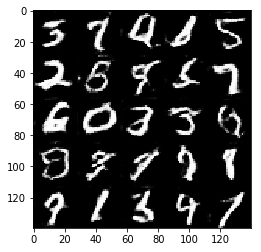

Epoch 2/2... Discriminator Loss: 0.9463... Generator Loss: 0.7799
Epoch 2/2... Discriminator Loss: 0.5954... Generator Loss: 1.3210
Epoch 2/2... Discriminator Loss: 1.6048... Generator Loss: 3.1475
Epoch 2/2... Discriminator Loss: 0.7868... Generator Loss: 0.8774
Epoch 2/2... Discriminator Loss: 0.8775... Generator Loss: 0.7859
Epoch 2/2... Discriminator Loss: 0.7193... Generator Loss: 0.9179
Epoch 2/2... Discriminator Loss: 0.8102... Generator Loss: 0.8451


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches, 
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4086... Generator Loss: 1.0790
Epoch 1/1... Discriminator Loss: 0.7525... Generator Loss: 1.3610
Epoch 1/1... Discriminator Loss: 0.6564... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 0.2445... Generator Loss: 1.1540
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 0.4480
Epoch 1/1... Discriminator Loss: 0.5225... Generator Loss: 1.2412
Epoch 1/1... Discriminator Loss: -0.1438... Generator Loss: 3.8103
Epoch 1/1... Discriminator Loss: 0.5068... Generator Loss: 1.2122
Epoch 1/1... Discriminator Loss: 0.2165... Generator Loss: 2.1220
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.4475


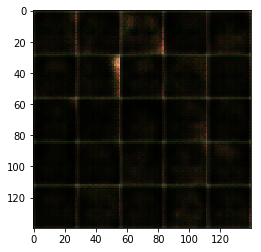

Epoch 1/1... Discriminator Loss: 0.6194... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.5254
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 5.6548
Epoch 1/1... Discriminator Loss: 1.9392... Generator Loss: 0.2574
Epoch 1/1... Discriminator Loss: 0.0559... Generator Loss: 3.7889
Epoch 1/1... Discriminator Loss: 0.0384... Generator Loss: 2.6153
Epoch 1/1... Discriminator Loss: 0.1574... Generator Loss: 2.4754
Epoch 1/1... Discriminator Loss: 0.3142... Generator Loss: 1.1987
Epoch 1/1... Discriminator Loss: 0.0448... Generator Loss: 2.1767


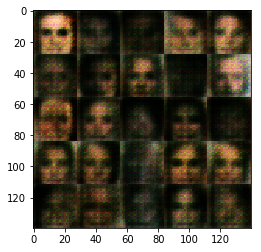

Epoch 1/1... Discriminator Loss: 1.6700... Generator Loss: 0.4012
Epoch 1/1... Discriminator Loss: 1.8398... Generator Loss: 0.2418
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 0.6856... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 0.6540... Generator Loss: 1.6008
Epoch 1/1... Discriminator Loss: 2.8284... Generator Loss: 0.0929
Epoch 1/1... Discriminator Loss: 0.2430... Generator Loss: 4.0993
Epoch 1/1... Discriminator Loss: 0.7930... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.5129
Epoch 1/1... Discriminator Loss: 0.4768... Generator Loss: 1.9662


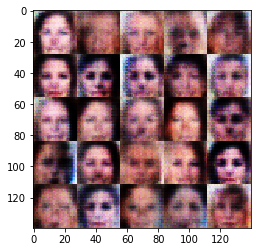

Epoch 1/1... Discriminator Loss: 0.4199... Generator Loss: 1.3453
Epoch 1/1... Discriminator Loss: 0.1767... Generator Loss: 2.8743
Epoch 1/1... Discriminator Loss: 0.4594... Generator Loss: 2.2863
Epoch 1/1... Discriminator Loss: 2.6760... Generator Loss: 0.0942
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 1.8402
Epoch 1/1... Discriminator Loss: 0.1884... Generator Loss: 6.2696
Epoch 1/1... Discriminator Loss: -0.0610... Generator Loss: 2.5376
Epoch 1/1... Discriminator Loss: 0.9054... Generator Loss: 5.5121
Epoch 1/1... Discriminator Loss: 0.0808... Generator Loss: 2.7015
Epoch 1/1... Discriminator Loss: 0.1122... Generator Loss: 6.3086


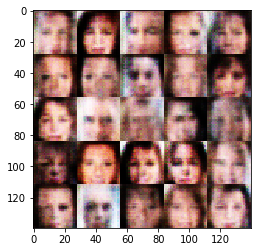

Epoch 1/1... Discriminator Loss: -0.0118... Generator Loss: 3.2159
Epoch 1/1... Discriminator Loss: -0.0858... Generator Loss: 3.9951
Epoch 1/1... Discriminator Loss: 0.0228... Generator Loss: 2.1137
Epoch 1/1... Discriminator Loss: 0.4282... Generator Loss: 1.1520
Epoch 1/1... Discriminator Loss: 0.1049... Generator Loss: 5.7234
Epoch 1/1... Discriminator Loss: 0.2677... Generator Loss: 2.0032
Epoch 1/1... Discriminator Loss: -0.2574... Generator Loss: 4.9550
Epoch 1/1... Discriminator Loss: -0.0313... Generator Loss: 3.1810
Epoch 1/1... Discriminator Loss: 0.1168... Generator Loss: 2.5623
Epoch 1/1... Discriminator Loss: -0.0089... Generator Loss: 6.1572


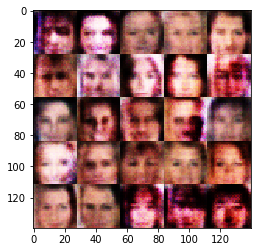

Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.3718
Epoch 1/1... Discriminator Loss: 1.8756... Generator Loss: 6.1732
Epoch 1/1... Discriminator Loss: 3.0769... Generator Loss: 0.0610
Epoch 1/1... Discriminator Loss: 3.0111... Generator Loss: 0.0558
Epoch 1/1... Discriminator Loss: 2.0871... Generator Loss: 0.1674
Epoch 1/1... Discriminator Loss: 0.4128... Generator Loss: 1.8604
Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 10.8792
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 0.0015... Generator Loss: 4.0402
Epoch 1/1... Discriminator Loss: -0.0172... Generator Loss: 2.2182


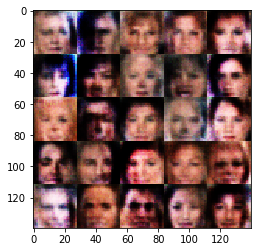

Epoch 1/1... Discriminator Loss: -0.1350... Generator Loss: 5.8569
Epoch 1/1... Discriminator Loss: -0.0678... Generator Loss: 4.4308
Epoch 1/1... Discriminator Loss: 4.6029... Generator Loss: 4.8979
Epoch 1/1... Discriminator Loss: 0.1211... Generator Loss: 1.6137
Epoch 1/1... Discriminator Loss: 0.0334... Generator Loss: 5.8441
Epoch 1/1... Discriminator Loss: 0.5665... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 0.4663
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 5.6741
Epoch 1/1... Discriminator Loss: 0.3269... Generator Loss: 1.5061
Epoch 1/1... Discriminator Loss: 2.0682... Generator Loss: 0.1471


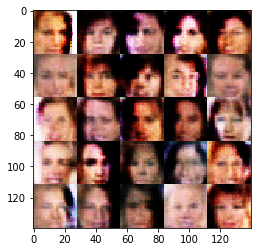

Epoch 1/1... Discriminator Loss: 0.0400... Generator Loss: 1.8321
Epoch 1/1... Discriminator Loss: -0.1146... Generator Loss: 6.0694
Epoch 1/1... Discriminator Loss: -0.0794... Generator Loss: 3.8346
Epoch 1/1... Discriminator Loss: -0.0661... Generator Loss: 7.5804
Epoch 1/1... Discriminator Loss: 0.4029... Generator Loss: 4.7739
Epoch 1/1... Discriminator Loss: 0.3873... Generator Loss: 1.0024
Epoch 1/1... Discriminator Loss: 0.0532... Generator Loss: 2.6176
Epoch 1/1... Discriminator Loss: 0.7131... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 0.0184... Generator Loss: 5.5029
Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 7.5649


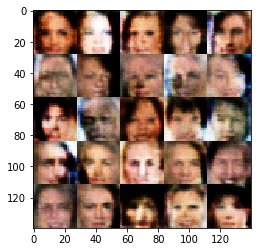

Epoch 1/1... Discriminator Loss: 0.5991... Generator Loss: 10.0315
Epoch 1/1... Discriminator Loss: -0.0668... Generator Loss: 6.1010
Epoch 1/1... Discriminator Loss: -0.0700... Generator Loss: 3.5535
Epoch 1/1... Discriminator Loss: -0.0420... Generator Loss: 5.6949
Epoch 1/1... Discriminator Loss: -0.1439... Generator Loss: 6.5023
Epoch 1/1... Discriminator Loss: 0.0953... Generator Loss: 2.2381
Epoch 1/1... Discriminator Loss: -0.0481... Generator Loss: 7.0443
Epoch 1/1... Discriminator Loss: -0.0632... Generator Loss: 3.2083
Epoch 1/1... Discriminator Loss: -0.1265... Generator Loss: 4.3055
Epoch 1/1... Discriminator Loss: 0.0551... Generator Loss: 3.0131


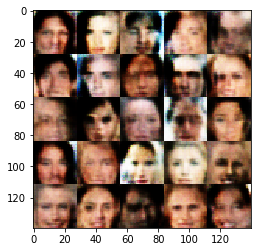

Epoch 1/1... Discriminator Loss: -0.1741... Generator Loss: 4.2800
Epoch 1/1... Discriminator Loss: 2.1416... Generator Loss: 0.1488
Epoch 1/1... Discriminator Loss: 0.0796... Generator Loss: 1.6741
Epoch 1/1... Discriminator Loss: 0.0929... Generator Loss: 1.8350
Epoch 1/1... Discriminator Loss: -0.0756... Generator Loss: 4.3910
Epoch 1/1... Discriminator Loss: -0.1392... Generator Loss: 5.0873
Epoch 1/1... Discriminator Loss: 0.0922... Generator Loss: 1.6548
Epoch 1/1... Discriminator Loss: -0.0507... Generator Loss: 2.2371
Epoch 1/1... Discriminator Loss: -0.1828... Generator Loss: 5.6891
Epoch 1/1... Discriminator Loss: 0.1466... Generator Loss: 4.4494


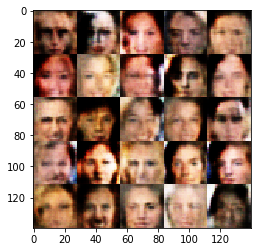

Epoch 1/1... Discriminator Loss: -0.0624... Generator Loss: 4.7555
Epoch 1/1... Discriminator Loss: -0.0952... Generator Loss: 5.3319
Epoch 1/1... Discriminator Loss: -0.1623... Generator Loss: 4.5564
Epoch 1/1... Discriminator Loss: -0.1160... Generator Loss: 3.3228
Epoch 1/1... Discriminator Loss: -0.0407... Generator Loss: 3.3273
Epoch 1/1... Discriminator Loss: -0.0791... Generator Loss: 2.3832
Epoch 1/1... Discriminator Loss: -0.2062... Generator Loss: 4.6683
Epoch 1/1... Discriminator Loss: -0.1762... Generator Loss: 8.5462
Epoch 1/1... Discriminator Loss: -0.1632... Generator Loss: 2.9625
Epoch 1/1... Discriminator Loss: 0.2691... Generator Loss: 1.0581


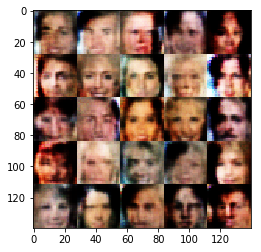

Epoch 1/1... Discriminator Loss: 0.1219... Generator Loss: 3.4219
Epoch 1/1... Discriminator Loss: -0.1033... Generator Loss: 2.9635
Epoch 1/1... Discriminator Loss: -0.1078... Generator Loss: 3.0635
Epoch 1/1... Discriminator Loss: 0.0963... Generator Loss: 5.5589
Epoch 1/1... Discriminator Loss: 2.6989... Generator Loss: 0.0995
Epoch 1/1... Discriminator Loss: 0.5400... Generator Loss: 1.3073
Epoch 1/1... Discriminator Loss: 0.0518... Generator Loss: 3.5974
Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: -0.0697... Generator Loss: 5.2803
Epoch 1/1... Discriminator Loss: -0.0225... Generator Loss: 4.0225


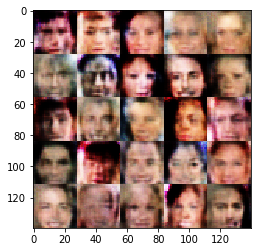

Epoch 1/1... Discriminator Loss: -0.1467... Generator Loss: 3.2838
Epoch 1/1... Discriminator Loss: -0.0973... Generator Loss: 3.0962
Epoch 1/1... Discriminator Loss: 0.0352... Generator Loss: 6.9820
Epoch 1/1... Discriminator Loss: -0.1446... Generator Loss: 2.7884
Epoch 1/1... Discriminator Loss: 0.2889... Generator Loss: 1.2452
Epoch 1/1... Discriminator Loss: 0.0779... Generator Loss: 1.8216
Epoch 1/1... Discriminator Loss: -0.2485... Generator Loss: 5.7666
Epoch 1/1... Discriminator Loss: -0.2038... Generator Loss: 4.8886
Epoch 1/1... Discriminator Loss: -0.0560... Generator Loss: 7.1044
Epoch 1/1... Discriminator Loss: 1.8665... Generator Loss: 0.3781


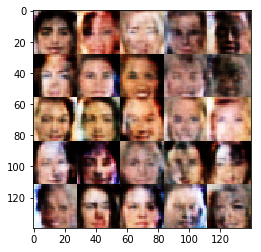

Epoch 1/1... Discriminator Loss: -0.1020... Generator Loss: 3.0950
Epoch 1/1... Discriminator Loss: -0.1120... Generator Loss: 3.5387
Epoch 1/1... Discriminator Loss: 0.0777... Generator Loss: 4.5945
Epoch 1/1... Discriminator Loss: -0.1810... Generator Loss: 5.9629
Epoch 1/1... Discriminator Loss: -0.0932... Generator Loss: 2.5984
Epoch 1/1... Discriminator Loss: 0.0571... Generator Loss: 1.7440
Epoch 1/1... Discriminator Loss: -0.1403... Generator Loss: 5.0050
Epoch 1/1... Discriminator Loss: 0.2748... Generator Loss: 1.1102
Epoch 1/1... Discriminator Loss: 3.1400... Generator Loss: 0.0536
Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 1.7929


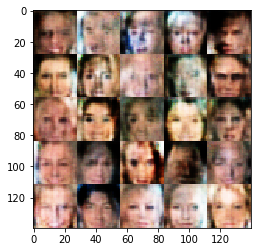

Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.3695
Epoch 1/1... Discriminator Loss: -0.0366... Generator Loss: 2.6335
Epoch 1/1... Discriminator Loss: -0.1298... Generator Loss: 4.6520
Epoch 1/1... Discriminator Loss: 0.5117... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: -0.0574... Generator Loss: 3.3657
Epoch 1/1... Discriminator Loss: -0.0712... Generator Loss: 2.5223
Epoch 1/1... Discriminator Loss: -0.1246... Generator Loss: 3.1927
Epoch 1/1... Discriminator Loss: -0.1083... Generator Loss: 3.6179
Epoch 1/1... Discriminator Loss: -0.0877... Generator Loss: 3.1258
Epoch 1/1... Discriminator Loss: -0.1140... Generator Loss: 4.7630


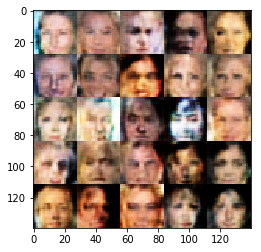

Epoch 1/1... Discriminator Loss: 0.0482... Generator Loss: 2.0945
Epoch 1/1... Discriminator Loss: -0.1915... Generator Loss: 4.2170
Epoch 1/1... Discriminator Loss: -0.1958... Generator Loss: 4.1061
Epoch 1/1... Discriminator Loss: -0.1342... Generator Loss: 4.0629
Epoch 1/1... Discriminator Loss: -0.1009... Generator Loss: 2.0007
Epoch 1/1... Discriminator Loss: 0.3173... Generator Loss: 1.2195
Epoch 1/1... Discriminator Loss: 4.2237... Generator Loss: 7.8797
Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 1.9019
Epoch 1/1... Discriminator Loss: 0.5824... Generator Loss: 1.1625
Epoch 1/1... Discriminator Loss: 0.2697... Generator Loss: 3.1130


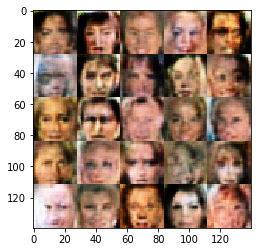

Epoch 1/1... Discriminator Loss: 0.1154... Generator Loss: 2.3475
Epoch 1/1... Discriminator Loss: 0.0059... Generator Loss: 2.9324
Epoch 1/1... Discriminator Loss: 0.4559... Generator Loss: 1.0077
Epoch 1/1... Discriminator Loss: -0.1335... Generator Loss: 4.1466
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.3961
Epoch 1/1... Discriminator Loss: -0.0880... Generator Loss: 5.1039
Epoch 1/1... Discriminator Loss: -0.0408... Generator Loss: 2.5132
Epoch 1/1... Discriminator Loss: -0.0638... Generator Loss: 4.6279
Epoch 1/1... Discriminator Loss: -0.0222... Generator Loss: 3.2964
Epoch 1/1... Discriminator Loss: 1.9434... Generator Loss: 0.2140


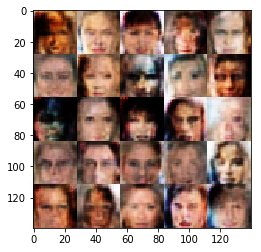

Epoch 1/1... Discriminator Loss: 0.2134... Generator Loss: 1.5826
Epoch 1/1... Discriminator Loss: -0.1938... Generator Loss: 3.8979
Epoch 1/1... Discriminator Loss: -0.0499... Generator Loss: 2.2210
Epoch 1/1... Discriminator Loss: -0.1990... Generator Loss: 4.6145
Epoch 1/1... Discriminator Loss: 0.5613... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: -0.1311... Generator Loss: 6.8038
Epoch 1/1... Discriminator Loss: -0.1906... Generator Loss: 5.0681
Epoch 1/1... Discriminator Loss: -0.0124... Generator Loss: 7.7609
Epoch 1/1... Discriminator Loss: -0.2267... Generator Loss: 3.8249
Epoch 1/1... Discriminator Loss: 0.3235... Generator Loss: 1.1797


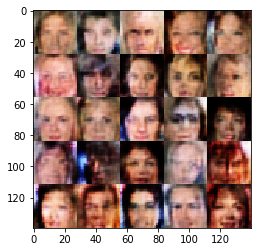

Epoch 1/1... Discriminator Loss: 0.0383... Generator Loss: 1.9596
Epoch 1/1... Discriminator Loss: -0.1726... Generator Loss: 7.1266
Epoch 1/1... Discriminator Loss: -0.2112... Generator Loss: 3.3286
Epoch 1/1... Discriminator Loss: 0.3671... Generator Loss: 5.5096
Epoch 1/1... Discriminator Loss: 2.0152... Generator Loss: 2.3784
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 1.0841
Epoch 1/1... Discriminator Loss: 0.5096... Generator Loss: 1.4077
Epoch 1/1... Discriminator Loss: 0.4299... Generator Loss: 1.3110
Epoch 1/1... Discriminator Loss: 0.6685... Generator Loss: 2.8318
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 0.4025


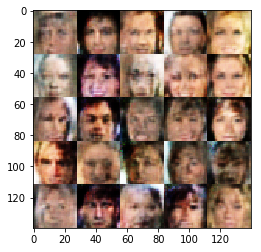

Epoch 1/1... Discriminator Loss: 0.0466... Generator Loss: 2.0119
Epoch 1/1... Discriminator Loss: 0.0585... Generator Loss: 1.8176
Epoch 1/1... Discriminator Loss: 0.1579... Generator Loss: 1.6110
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.5163
Epoch 1/1... Discriminator Loss: 0.0295... Generator Loss: 2.6566
Epoch 1/1... Discriminator Loss: 0.4379... Generator Loss: 3.3789
Epoch 1/1... Discriminator Loss: 0.2402... Generator Loss: 1.3122
Epoch 1/1... Discriminator Loss: 0.0848... Generator Loss: 2.4889
Epoch 1/1... Discriminator Loss: 0.2340... Generator Loss: 1.7481
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.4088


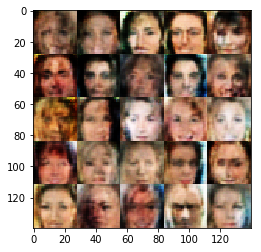

Epoch 1/1... Discriminator Loss: -0.1474... Generator Loss: 6.1542
Epoch 1/1... Discriminator Loss: 0.2190... Generator Loss: 1.4947
Epoch 1/1... Discriminator Loss: 0.1236... Generator Loss: 1.4030
Epoch 1/1... Discriminator Loss: 0.2496... Generator Loss: 2.2644
Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: -0.1965... Generator Loss: 3.5794
Epoch 1/1... Discriminator Loss: 2.9115... Generator Loss: 0.2163
Epoch 1/1... Discriminator Loss: 0.4298... Generator Loss: 1.4300
Epoch 1/1... Discriminator Loss: 0.2827... Generator Loss: 2.4542
Epoch 1/1... Discriminator Loss: 0.4551... Generator Loss: 1.1834


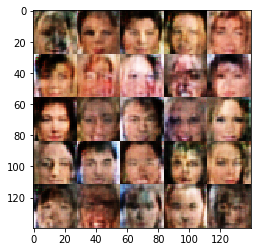

Epoch 1/1... Discriminator Loss: 0.6080... Generator Loss: 1.1489
Epoch 1/1... Discriminator Loss: 0.7696... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.6282... Generator Loss: 0.2358
Epoch 1/1... Discriminator Loss: 0.4752... Generator Loss: 1.0172
Epoch 1/1... Discriminator Loss: 0.2975... Generator Loss: 3.8972
Epoch 1/1... Discriminator Loss: 0.0243... Generator Loss: 2.6759
Epoch 1/1... Discriminator Loss: -0.0051... Generator Loss: 3.0073
Epoch 1/1... Discriminator Loss: -0.0591... Generator Loss: 2.0813
Epoch 1/1... Discriminator Loss: 0.4670... Generator Loss: 1.0225
Epoch 1/1... Discriminator Loss: -0.1307... Generator Loss: 2.6359


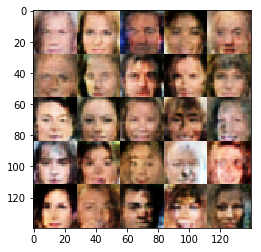

Epoch 1/1... Discriminator Loss: -0.2340... Generator Loss: 3.4017
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 0.5224
Epoch 1/1... Discriminator Loss: 0.6161... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 0.7696... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 0.4985... Generator Loss: 0.9743
Epoch 1/1... Discriminator Loss: -0.0080... Generator Loss: 2.0112
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 4.6546
Epoch 1/1... Discriminator Loss: -0.0282... Generator Loss: 2.2590
Epoch 1/1... Discriminator Loss: 0.0735... Generator Loss: 5.3563
Epoch 1/1... Discriminator Loss: 2.2696... Generator Loss: 0.1466


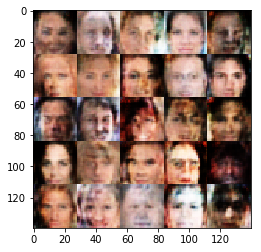

Epoch 1/1... Discriminator Loss: 0.2838... Generator Loss: 1.3750
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 0.1756... Generator Loss: 1.4475
Epoch 1/1... Discriminator Loss: 0.6323... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 0.2191... Generator Loss: 1.3973
Epoch 1/1... Discriminator Loss: 0.1430... Generator Loss: 1.5368
Epoch 1/1... Discriminator Loss: 0.1972... Generator Loss: 1.4405
Epoch 1/1... Discriminator Loss: 0.4060... Generator Loss: 1.1237
Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.3991
Epoch 1/1... Discriminator Loss: 0.1137... Generator Loss: 2.7972


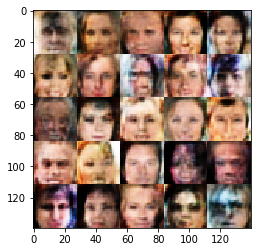

Epoch 1/1... Discriminator Loss: 0.2772... Generator Loss: 1.9973
Epoch 1/1... Discriminator Loss: 0.1470... Generator Loss: 1.7029
Epoch 1/1... Discriminator Loss: 0.2548... Generator Loss: 1.1953
Epoch 1/1... Discriminator Loss: 0.0243... Generator Loss: 3.2126
Epoch 1/1... Discriminator Loss: -0.1364... Generator Loss: 7.3816
Epoch 1/1... Discriminator Loss: 0.2035... Generator Loss: 2.0217
Epoch 1/1... Discriminator Loss: -0.1221... Generator Loss: 2.8858
Epoch 1/1... Discriminator Loss: 0.4126... Generator Loss: 4.7323
Epoch 1/1... Discriminator Loss: 0.7416... Generator Loss: 1.2337
Epoch 1/1... Discriminator Loss: 0.5552... Generator Loss: 1.1541


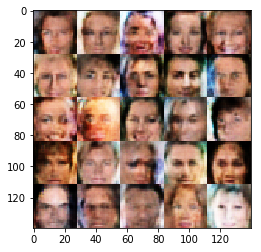

Epoch 1/1... Discriminator Loss: 0.5483... Generator Loss: 2.4249
Epoch 1/1... Discriminator Loss: 0.4425... Generator Loss: 1.1617
Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 0.2026... Generator Loss: 1.7219
Epoch 1/1... Discriminator Loss: 0.5304... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.3808
Epoch 1/1... Discriminator Loss: -0.0995... Generator Loss: 2.3379
Epoch 1/1... Discriminator Loss: 0.0180... Generator Loss: 6.1747


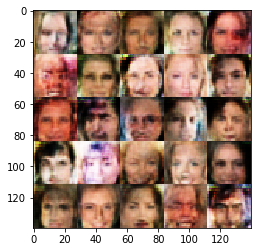

Epoch 1/1... Discriminator Loss: 0.0434... Generator Loss: 2.0003
Epoch 1/1... Discriminator Loss: 0.2238... Generator Loss: 1.5137
Epoch 1/1... Discriminator Loss: 0.1224... Generator Loss: 1.8739
Epoch 1/1... Discriminator Loss: 0.0207... Generator Loss: 5.9890
Epoch 1/1... Discriminator Loss: -0.1510... Generator Loss: 4.1979
Epoch 1/1... Discriminator Loss: 0.0955... Generator Loss: 2.6447
Epoch 1/1... Discriminator Loss: 2.0296... Generator Loss: 0.1950
Epoch 1/1... Discriminator Loss: 0.5917... Generator Loss: 1.1126
Epoch 1/1... Discriminator Loss: 0.1944... Generator Loss: 2.8277
Epoch 1/1... Discriminator Loss: -0.0248... Generator Loss: 3.8204


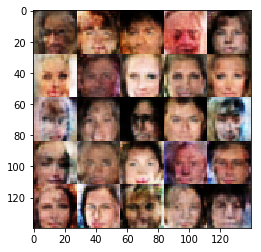

Epoch 1/1... Discriminator Loss: -0.2110... Generator Loss: 3.4547
Epoch 1/1... Discriminator Loss: 0.1101... Generator Loss: 2.0396
Epoch 1/1... Discriminator Loss: -0.0123... Generator Loss: 5.2218
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.3300
Epoch 1/1... Discriminator Loss: 0.5301... Generator Loss: 4.4192
Epoch 1/1... Discriminator Loss: 0.0229... Generator Loss: 1.8831
Epoch 1/1... Discriminator Loss: -0.1741... Generator Loss: 4.8814
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 0.4452... Generator Loss: 1.4878
Epoch 1/1... Discriminator Loss: 0.2197... Generator Loss: 2.2108


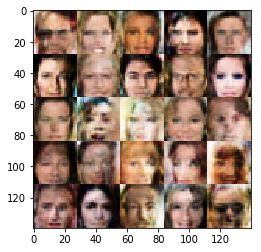

Epoch 1/1... Discriminator Loss: 0.1638... Generator Loss: 1.7084
Epoch 1/1... Discriminator Loss: -0.0466... Generator Loss: 2.6866
Epoch 1/1... Discriminator Loss: 0.1492... Generator Loss: 2.3968
Epoch 1/1... Discriminator Loss: -0.0472... Generator Loss: 2.6677
Epoch 1/1... Discriminator Loss: 0.0514... Generator Loss: 3.8557
Epoch 1/1... Discriminator Loss: 1.7638... Generator Loss: 0.2543
Epoch 1/1... Discriminator Loss: -0.0748... Generator Loss: 2.7810
Epoch 1/1... Discriminator Loss: 0.2144... Generator Loss: 1.9486
Epoch 1/1... Discriminator Loss: 0.3204... Generator Loss: 1.2463
Epoch 1/1... Discriminator Loss: 0.2378... Generator Loss: 1.5621


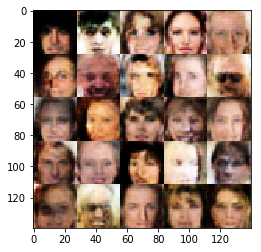

Epoch 1/1... Discriminator Loss: 0.3148... Generator Loss: 1.2009
Epoch 1/1... Discriminator Loss: -0.1582... Generator Loss: 4.2152
Epoch 1/1... Discriminator Loss: 0.0939... Generator Loss: 1.7487
Epoch 1/1... Discriminator Loss: 0.4755... Generator Loss: 1.0094
Epoch 1/1... Discriminator Loss: 0.0200... Generator Loss: 2.6172
Epoch 1/1... Discriminator Loss: -0.0246... Generator Loss: 3.2547
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 0.6730... Generator Loss: 1.8931
Epoch 1/1... Discriminator Loss: 0.1980... Generator Loss: 1.8003
Epoch 1/1... Discriminator Loss: 0.5332... Generator Loss: 1.0662


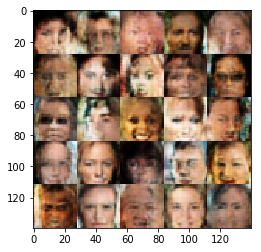

Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.4748
Epoch 1/1... Discriminator Loss: 1.9394... Generator Loss: 0.1899
Epoch 1/1... Discriminator Loss: 0.5975... Generator Loss: 4.2599
Epoch 1/1... Discriminator Loss: -0.0150... Generator Loss: 3.4548
Epoch 1/1... Discriminator Loss: -0.0334... Generator Loss: 2.5034
Epoch 1/1... Discriminator Loss: 1.8318... Generator Loss: 0.2267
Epoch 1/1... Discriminator Loss: 0.2952... Generator Loss: 2.4577
Epoch 1/1... Discriminator Loss: 0.2763... Generator Loss: 1.3108
Epoch 1/1... Discriminator Loss: 0.0902... Generator Loss: 6.5270
Epoch 1/1... Discriminator Loss: 0.0164... Generator Loss: 2.1942


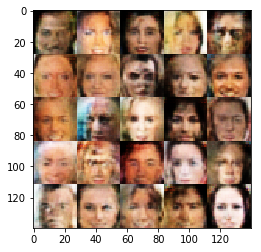

Epoch 1/1... Discriminator Loss: -0.1738... Generator Loss: 3.9075
Epoch 1/1... Discriminator Loss: -0.0795... Generator Loss: 2.5197
Epoch 1/1... Discriminator Loss: 1.8601... Generator Loss: 0.2740
Epoch 1/1... Discriminator Loss: 0.3629... Generator Loss: 1.5930
Epoch 1/1... Discriminator Loss: 1.5937... Generator Loss: 0.2951
Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 0.6586


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.